# ID3 Decision Tree

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('data.csv').drop(columns = ['S.No'])
data.head()

,Branch,CGPA,Gamer,Movie Fanatic,Committed?
0,CSE,High,Yes,No,No
1,CSE,Low,Yes,No,No
2,CSE,High,Yes,Yes,No
3,CSE,High,No,No,Yes
4,CSE,Low,No,Yes,Yes


In [3]:
def calculateEntropy(data):
    labels = data.iloc[:, -1].value_counts().keys().tolist()
    instances = data.shape[0]
    entropy = 0
    for i in range(len(labels)):
        label = labels[i]
        label_count = data.iloc[:, -1].value_counts().tolist()[i]
        class_probability = label_count/instances
        entropy = entropy - class_probability * math.log2(class_probability)
    return entropy

def f(col_name, data):
    labels = data.iloc[:, -1].tolist()
    col = data[col_name]
    values = col.value_counts().keys().tolist()
    ent = {}
    for i in values:
        yes = 0
        no = 0
        for j in range(len(col)):
            if col.tolist()[j]==i:
                if labels[j]=='Yes':
                    yes+=1
                else:
                    no+=1
        instances = list(col).count(i)
        p_yes = yes/instances
        p_no = no/instances
        if p_yes ==0:
            entropy = - p_no*(math.log2(p_no))
        elif p_no ==0:
            entropy = -p_yes*(math.log2(p_yes))
        else:
            entropy = -p_yes*(math.log2(p_yes)) - p_no*(math.log2(p_no))
        ent[i] = entropy
    return ent

def calculateGain(data, col_name, ent_des, ent_col):
    col = data[col_name]
    values = col.value_counts().keys().tolist()
    instances = col.shape[0]
    gain = ent_des
    col = col.tolist()
    for i in values:
        count = col.count(i)
        gain = gain - (count/instances)*ent_col[i]
    return gain

def gain(data, original_data):
    ent_des = calculateEntropy(original_data)
    columns = data.columns[1:-1]
    gains = {}
    for col in columns:
        gains[col] = calculateGain(data, col, ent_des, f(col, data))
    return gains

def ID3(data, original_data, features, parent_node_class = None):
    if len(np.unique(data['Committed?'])) <= 1:
        return np.unique(data['Committed?'])[0]
    elif len(data)==0:
        return np.unique(originaldata['Committed?'])[np.argmax(np.unique(originaldata['Committed?'],return_counts=True)[1])]
    elif len(features) ==0:
        return parent_node_class
    else:
        parent_node_class = np.unique(data['Committed?'])[np.argmax(np.unique(data['Committed?'],return_counts=True)[1])]
        item_values = [calculateGain(data, feature, calculateEntropy(data), f(feature, original_data)) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        tree = {best_feature:{}}
        features = [i for i in features if i != best_feature]
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()

            subtree = ID3(sub_data,original_data,features,parent_node_class)
            tree[best_feature][value] = subtree
        return(tree)
    
def predict(query,tree,default = 1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            result = tree[key][query[key]]

            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [4]:
dtree = ID3(data, data, ['Branch', 'CGPA', 'Gamer', 'Movie Fanatic'])
dtree

{'Gamer': {'No': {'Branch': {'CSE': 'Yes',
    'ECE': 'Yes',
    'MECH': {'CGPA': {'High': {'Movie Fanatic': {'No': 'No'}},
      'Low': 'Yes'}}}},
  'Yes': {'Branch': {'CSE': 'No',
    'ECE': {'Movie Fanatic': {'No': 'No',
      'Yes': {'CGPA': {'High': 'Yes', 'Low': 'No'}}}},
    'MECH': 'No'}}}}

In [5]:
test_data = pd.read_csv('test_data.csv').drop(columns = ['S.No.'])
X_test = test_data.to_dict(orient='records')
y_test = list(test_data.iloc[:, -1])
y_pred = [predict(query, dtree) for query in X_test]

In [6]:
print('Predicted Values : ', y_pred)
print('Actual Values : ', y_test)

Predicted Values :  ['Yes', 'No', 'Yes']
Actual Values :  ['Yes', 'No', 'No']


In [7]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy : ', accuracy)

Accuracy :  0.6666666666666666


# CART Decision Tree

## Part - 1

In [8]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import graphviz

In [9]:
data1 = pd.read_csv('data.csv').drop(columns = ['S.No'])
data1.head(5)

,Branch,CGPA,Gamer,Movie Fanatic,Committed?
0,CSE,High,Yes,No,No
1,CSE,Low,Yes,No,No
2,CSE,High,Yes,Yes,No
3,CSE,High,No,No,Yes
4,CSE,Low,No,Yes,Yes


In [10]:
# Data preprocessing
data1['Committed?'],class_names = pd.factorize(data1['Committed?'])
for col_name in data1.columns:
    data1[col_name],_ = pd.factorize(data1[col_name])
data1

,Branch,CGPA,Gamer,Movie Fanatic,Committed?
0,0,0,0,0,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,1,0,1
4,0,1,1,1,1
5,1,1,0,0,0
6,1,0,0,1,1
7,1,1,0,1,0
8,1,0,0,1,1
9,1,0,1,1,1


In [11]:
X_train = data1.iloc[:,:-1]
y_train = data1.iloc[:,-1]

In [12]:
dtree = tree.DecisionTreeClassifier(criterion='gini', max_depth = 3, random_state=0)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [13]:
test_data1 = pd.read_csv('test_data.csv').drop(columns = ['S.No.'])
for col_name in test_data1.columns:
    test_data1[col_name],_ = pd.factorize(test_data1[col_name])
test_data1

,Branch,CGPA,Gamer,Movie Fanatic,Committed?
0,0,0,0,0,0
1,1,1,1,1,1
2,2,1,0,0,1


In [14]:
X_test = test_data1.iloc[:, :-1]
y_test = test_data1.iloc[:, -1]

In [15]:
y_pred = dtree.predict(X_test)
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 1
Accuracy: 0.67


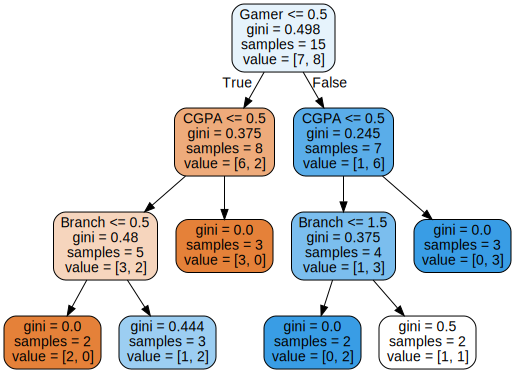

In [16]:
feature_names = X_train.columns

dot_data = tree.export_graphviz(dtree, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names)
graph = graphviz.Source(dot_data)  
graph

## Part - 2

In [17]:
data2 = pd.read_csv('car.data', names=['buying','maint','doors','persons','lug_boot','safety','class'])
data2.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [18]:
data2['class'],class_names = pd.factorize(data2['class'])
for col_name in data2.columns:
    data2[col_name],_ = pd.factorize(data2[col_name])

In [19]:
X = data2.iloc[:,:-1]
y = data2.iloc[:,-1]

In [20]:
# split data randomly into 70% training and 30% test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
dtree1 = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
dtree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [22]:
y_pred = dtree1.predict(X_test)
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 96
Accuracy: 0.82


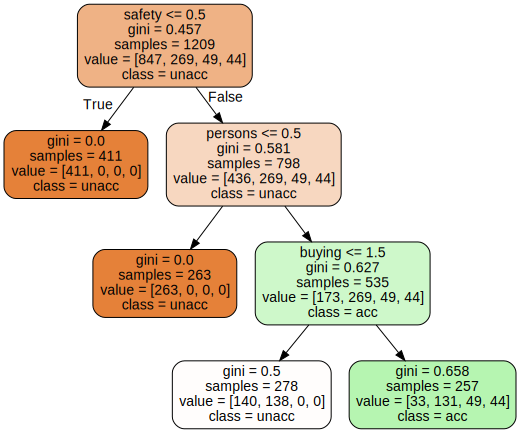

In [23]:
feature_names = X.columns
dot_data = tree.export_graphviz(dtree1, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(dot_data)  
graph